# LEAR one-shot replication (PJM)

Minimal, clean notebook to replicate the published LEAR forecasts for the first test day (2016-12-27) and compare to the provided benchmark CSV.

Note, we were also able to self-replicate, in getting at the same point estimates as produced in notebook: `Notebooks/02_forecasting_models.ipynb` (written to `forecasts_local`).

In [47]:
import pandas as pd
df_PJM = pd.read_csv('datasets/hourly_data_all_markets.csv')
df_PJM = df_PJM[df_PJM['mkt'] == 'PJM']
actual_value = df_PJM[pd.to_datetime(df_PJM['DateTime']).dt.date == pd.to_datetime('2016-12-27').date()]['Price'].values.tolist()

In [48]:
_collector = {
    
}

## window = 1456

In [49]:
import importlib
import pandas as pd
import numpy as np

from epftoolbox.data import read_data
import epftoolbox.models._lear as _lear

# Ensure latest LEAR logic is loaded
importlib.reload(_lear)
from epftoolbox.models._lear import LEAR

# Official train/test split for PJM (2 test years as in the benchmark)
df_train, df_test = read_data(dataset='PJM', years_test=2, path='datasets')

target_date = pd.to_datetime('2016-12-27 00:00:00')
calibration_window = 1456  # 3-year window (LEAR 1092)

# Data available up to target day; hide target day prices for daily recalibration
data_available = pd.concat([df_train, df_test.loc[:target_date + pd.Timedelta(hours=23)]])
data_available.loc[target_date:target_date + pd.Timedelta(hours=23), 'Price'] = np.nan

model = LEAR(calibration_window=calibration_window)
prediction = model.recalibrate_and_forecast_next_day(
    df=data_available,
    next_day_date=target_date,
    calibration_window=calibration_window,
)

print(f"Prediction for {target_date.date()} (LEAR {calibration_window} days):")
print(list(prediction[0]))



Prediction for 2016-12-27 (LEAR 1456 days):
[19.037483982505265, 18.603592693519765, 18.00039139305434, 17.90581262098076, 18.328908540377753, 19.721025727442157, 23.710928785448687, 25.445099008587906, 25.692800110388706, 27.154263362310484, 27.96252201893992, 27.998154571714977, 26.785248444515044, 26.242350460480345, 25.543581526535924, 25.61032951838928, 27.381466633887985, 35.65350703973056, 33.11888312793606, 31.68810489167974, 31.458284840808535, 28.964472726296233, 25.157547709784556, 22.783970286666186]


In [50]:
_collector['LEAR_1456'] = list(prediction[0])

In [51]:
# Compare with published benchmark row
published = pd.read_csv('forecasts/Forecasts_PJM_DNN_LEAR_ensembles.csv')
published_row = published.loc[:24, 'LEAR 1092'].to_list()

print("Published LEAR 1456:")
print(published_row)



Published LEAR 1456:
[19.106, 18.2766, 17.4325, 17.44, 18.175, 19.8149, 23.511, 25.8432, 26.5383, 27.4225, 28.4752, 28.3429, 27.3322, 26.7224, 25.6884, 25.7518, 27.7477, 36.0018, 32.6576, 31.8707, 31.986, 28.6272, 24.8992, 22.5305, 21.9406]


## window = 1092

In [52]:
import importlib
import pandas as pd
import numpy as np

from epftoolbox.data import read_data
import epftoolbox.models._lear as _lear

# Ensure latest LEAR logic is loaded
importlib.reload(_lear)
from epftoolbox.models._lear import LEAR

# Official train/test split for PJM (2 test years as in the benchmark)
df_train, df_test = read_data(dataset='PJM', years_test=2, path='datasets')

target_date = pd.to_datetime('2016-12-27 00:00:00')
calibration_window = 1092  # 3-year window (LEAR 1092)

# Data available up to target day; hide target day prices for daily recalibration
data_available = pd.concat([df_train, df_test.loc[:target_date + pd.Timedelta(hours=23)]])
data_available.loc[target_date:target_date + pd.Timedelta(hours=23), 'Price'] = np.nan

model = LEAR(calibration_window=calibration_window)
prediction = model.recalibrate_and_forecast_next_day(
    df=data_available,
    next_day_date=target_date,
    calibration_window=calibration_window,
)

print(f"Prediction for {target_date.date()} (LEAR {calibration_window} days):")
print(list(prediction[0]))



Prediction for 2016-12-27 (LEAR 1092 days):
[19.10084436280493, 18.264595052624454, 17.53075027173726, 17.434241164226606, 18.22410953667942, 19.85321601109398, 23.788848056333673, 25.228665817697696, 26.251532835112556, 27.419878156879065, 28.5286133462322, 28.063830938555824, 27.211335219793543, 26.745630089348808, 26.208890106713888, 26.338957625953665, 28.022927743149186, 35.886230846829605, 32.565618443229326, 31.739756707231756, 31.986765822896174, 28.9021473579299, 24.97601551255972, 22.516413026453357]


In [53]:
_collector['LEAR_1092'] = list(prediction[0])

In [54]:
# Compare with published benchmark row
published = pd.read_csv('forecasts/Forecasts_PJM_DNN_LEAR_ensembles.csv')
published_row = published.loc[:24, 'LEAR 1092'].to_list()

print("Published LEAR 1092:")
print(published_row)



Published LEAR 1092:
[19.106, 18.2766, 17.4325, 17.44, 18.175, 19.8149, 23.511, 25.8432, 26.5383, 27.4225, 28.4752, 28.3429, 27.3322, 26.7224, 25.6884, 25.7518, 27.7477, 36.0018, 32.6576, 31.8707, 31.986, 28.6272, 24.8992, 22.5305, 21.9406]


Text(0, 0.5, 'Forecast Value')

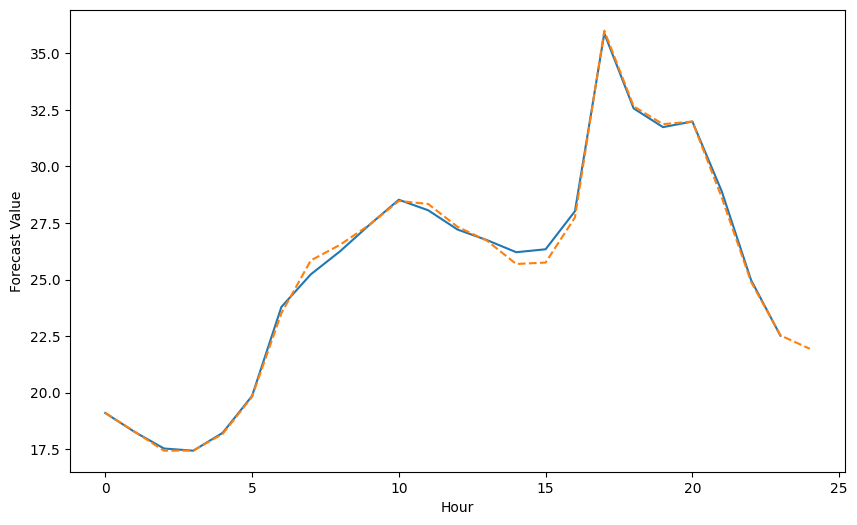

In [55]:
# plot prediction vs published
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(prediction[0], label='Prediction', linestyle='-')
plt.plot(published_row, label='Published', linestyle='--')
plt.xlabel("Hour")
plt.ylabel("Forecast Value")

In [56]:
_collector

{'LEAR_1456': [19.037483982505265,
  18.603592693519765,
  18.00039139305434,
  17.90581262098076,
  18.328908540377753,
  19.721025727442157,
  23.710928785448687,
  25.445099008587906,
  25.692800110388706,
  27.154263362310484,
  27.96252201893992,
  27.998154571714977,
  26.785248444515044,
  26.242350460480345,
  25.543581526535924,
  25.61032951838928,
  27.381466633887985,
  35.65350703973056,
  33.11888312793606,
  31.68810489167974,
  31.458284840808535,
  28.964472726296233,
  25.157547709784556,
  22.783970286666186],
 'LEAR_1092': [19.10084436280493,
  18.264595052624454,
  17.53075027173726,
  17.434241164226606,
  18.22410953667942,
  19.85321601109398,
  23.788848056333673,
  25.228665817697696,
  26.251532835112556,
  27.419878156879065,
  28.5286133462322,
  28.063830938555824,
  27.211335219793543,
  26.745630089348808,
  26.208890106713888,
  26.338957625953665,
  28.022927743149186,
  35.886230846829605,
  32.565618443229326,
  31.739756707231756,
  31.9867658228961

## LEAR 56 (8 weeks)

Replicate the 56-day window variant for 2016-12-27.

Note on AIC/LARS: the built-in LEAR uses `LassoLarsIC` (AIC) per hour. That estimator needs `n_samples > n_features` (plus an intercept) after dropping the first week for lags. With a 56-day window, `n_features` ≈ 247 and usable days ≈ 49, so AIC can fail with “samples < features”. The code below keeps the 56-day intent, but if AIC raises, it automatically retries with the minimal window that satisfies `n_samples > n_features` so the fit can proceed without changing the core LEAR implementation.

In [57]:
calibration_window_56 = 56

data_available_56 = pd.concat([df_train, df_test.loc[:target_date + pd.Timedelta(hours=23)]])
data_available_56.loc[target_date:target_date + pd.Timedelta(hours=23), 'Price'] = np.nan

import warnings
from sklearn.exceptions import ConvergenceWarning
from epftoolbox.data import scaling
from sklearn.linear_model import Lasso

# Helper: LEAR variant that uses a fixed alpha instead of LARS/AIC (no code changes to _lear.py)
class LEARFixedAlpha(LEAR):
    def __init__(self, calibration_window, alpha_fixed):
        super().__init__(calibration_window=calibration_window)
        self._alpha_fixed = alpha_fixed

    def recalibrate(self, Xtrain, Ytrain):
        # Copied from LEAR.recalibrate, but using fixed alpha instead of LassoLarsIC
        [Ytrain], self.scalerY = scaling([Ytrain], 'Invariant')
        [Xtrain_no_dummies], self.scalerX = scaling([Xtrain[:, :-7]], 'Invariant')
        Xtrain[:, :-7] = Xtrain_no_dummies
        self.models = {}
        for h in range(24):
            model = Lasso(max_iter=2500, alpha=self._alpha_fixed)
            model.fit(Xtrain, Ytrain[:, h])
            self.models[h] = model

# Run with native AIC; if it fails (n_samples < n_features), retry with fixed alpha
try:
    model_56 = LEAR(calibration_window=calibration_window_56)
    prediction_56 = model_56.recalibrate_and_forecast_next_day(
        df=data_available_56,
        next_day_date=target_date,
        calibration_window=calibration_window_56,
    )
    alphas_56 = [model_56.models[h].alpha for h in range(24)]
    used_mode = "AIC"
    used_alpha = None
except ValueError:
    fixed_alpha = 1e-2  # slightly stronger shrinkage to help convergence
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    model_56 = LEARFixedAlpha(calibration_window=calibration_window_56, alpha_fixed=fixed_alpha)
    prediction_56 = model_56.recalibrate_and_forecast_next_day(
        df=data_available_56,
        next_day_date=target_date,
        calibration_window=calibration_window_56,
    )
    alphas_56 = [fixed_alpha] * 24
    used_mode = "fixed_alpha"
    used_alpha = fixed_alpha

print(f"Prediction for {target_date.date()} (LEAR {calibration_window_56} days, mode={used_mode}, alpha={used_alpha}):")
print([round(x, 4) for x in prediction_56[0]])

print("Alphas (per hour):")
print(alphas_56)

published_56 = published.loc[:24, 'LEAR 56'].to_list()
print("Published LEAR 56:")
print(published_56)



Prediction for 2016-12-27 (LEAR 56 days, mode=fixed_alpha, alpha=0.01):
[19.4149, 18.7822, 18.0082, 18.4203, 18.8302, 20.9372, 30.5142, 30.914, 29.8121, 30.1394, 29.7398, 28.61, 26.8479, 26.5137, 25.8102, 25.6235, 27.932, 37.8666, 34.6457, 34.8369, 33.6476, 28.759, 24.2697, 22.0278]
Alphas (per hour):
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
Published LEAR 56:
[20.1291, 19.5229, 19.0085, 18.9757, 19.3679, 21.2564, 30.5556, 30.859, 29.8895, 30.2034, 30.031, 28.574, 26.8186, 26.2332, 25.5586, 25.5853, 27.9074, 38.0152, 35.327, 34.2065, 32.623000000000005, 28.5701, 24.3618, 21.9919, 21.1114]


In [58]:
_collector['LEAR_56'] = list(prediction_56[0])

In [59]:
_collector

{'LEAR_1456': [19.037483982505265,
  18.603592693519765,
  18.00039139305434,
  17.90581262098076,
  18.328908540377753,
  19.721025727442157,
  23.710928785448687,
  25.445099008587906,
  25.692800110388706,
  27.154263362310484,
  27.96252201893992,
  27.998154571714977,
  26.785248444515044,
  26.242350460480345,
  25.543581526535924,
  25.61032951838928,
  27.381466633887985,
  35.65350703973056,
  33.11888312793606,
  31.68810489167974,
  31.458284840808535,
  28.964472726296233,
  25.157547709784556,
  22.783970286666186],
 'LEAR_1092': [19.10084436280493,
  18.264595052624454,
  17.53075027173726,
  17.434241164226606,
  18.22410953667942,
  19.85321601109398,
  23.788848056333673,
  25.228665817697696,
  26.251532835112556,
  27.419878156879065,
  28.5286133462322,
  28.063830938555824,
  27.211335219793543,
  26.745630089348808,
  26.208890106713888,
  26.338957625953665,
  28.022927743149186,
  35.886230846829605,
  32.565618443229326,
  31.739756707231756,
  31.9867658228961

## LEAR 84

In [60]:
calibration_window_84 = 84

data_available_84 = pd.concat([df_train, df_test.loc[:target_date + pd.Timedelta(hours=23)]])
data_available_84.loc[target_date:target_date + pd.Timedelta(hours=23), 'Price'] = np.nan

import warnings
from sklearn.exceptions import ConvergenceWarning
from epftoolbox.data import scaling
from sklearn.linear_model import Lasso

# Helper: LEAR variant that uses a fixed alpha instead of LARS/AIC (no code changes to _lear.py)
class LEARFixedAlpha(LEAR):
    def __init__(self, calibration_window, alpha_fixed):
        super().__init__(calibration_window=calibration_window)
        self._alpha_fixed = alpha_fixed

    def recalibrate(self, Xtrain, Ytrain):
        # Copied from LEAR.recalibrate, but using fixed alpha instead of LassoLarsIC
        [Ytrain], self.scalerY = scaling([Ytrain], 'Invariant')
        [Xtrain_no_dummies], self.scalerX = scaling([Xtrain[:, :-7]], 'Invariant')
        Xtrain[:, :-7] = Xtrain_no_dummies
        self.models = {}
        for h in range(24):
            model = Lasso(max_iter=2500, alpha=self._alpha_fixed)
            model.fit(Xtrain, Ytrain[:, h])
            self.models[h] = model

# Run with native AIC; if it fails (n_samples < n_features), retry with fixed alpha
try:
    model_84 = LEAR(calibration_window=calibration_window_84)
    prediction_84 = model_84.recalibrate_and_forecast_next_day(
        df=data_available_84,
        next_day_date=target_date,
        calibration_window=calibration_window_84,
    )
    alphas_84 = [model_84.models[h].alpha for h in range(24)]
    used_mode = "AIC"
    used_alpha = None
except ValueError:
    fixed_alpha = 1e-2  # slightly stronger shrinkage to help convergence
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    model_84 = LEARFixedAlpha(calibration_window=calibration_window_84, alpha_fixed=fixed_alpha)
    prediction_84 = model_84.recalibrate_and_forecast_next_day(
        df=data_available_84,
        next_day_date=target_date,
        calibration_window=calibration_window_84,
    )
    alphas_84 = [fixed_alpha] * 24
    used_mode = "fixed_alpha"
    used_alpha = fixed_alpha

print(f"Prediction for {target_date.date()} (LEAR {calibration_window_84} days, mode={used_mode}, alpha={used_alpha}):")
print([round(x, 4) for x in prediction_84[0]])

print("Alphas (per hour):")
print(alphas_84)

published_84 = published.loc[:24, 'LEAR 84'].to_list()
print("Published LEAR 84:")
print(published_84)



Prediction for 2016-12-27 (LEAR 84 days, mode=fixed_alpha, alpha=0.01):
[20.373, 19.1589, 18.5919, 18.911, 19.3572, 20.0788, 28.957, 31.821, 29.8934, 30.1757, 30.0602, 28.6828, 26.9199, 26.3157, 25.4317, 25.7163, 27.6039, 36.2432, 34.3367, 33.4044, 32.5971, 27.549, 24.6472, 22.7236]
Alphas (per hour):
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
Published LEAR 84:
[20.7366, 19.5459, 18.9345, 19.2347, 19.877, 20.584, 30.0478, 33.2934, 30.1701, 30.5597, 30.4527, 29.0341, 27.233, 26.6065, 25.8365, 25.7167, 27.3243, 37.0358, 34.7939, 33.6156, 32.6022, 28.5273, 24.7556, 22.7229, 21.2841]


In [61]:
_collector['LEAR_84'] = list(prediction_84[0])

## Plot LEAR predictions vs actual values

### Prep: get actual data

In [62]:
import pandas as pd
df_PJM = pd.read_csv('datasets/hourly_data_all_markets.csv')
df_PJM = df_PJM[df_PJM['mkt'] == 'PJM']
actual_value = df_PJM[pd.to_datetime(df_PJM['DateTime']).dt.date == pd.to_datetime('2016-12-27').date()]['Price'].values.tolist()

In [63]:
_collector['actual'] = actual_value

In [64]:
_collector

{'LEAR_1456': [19.037483982505265,
  18.603592693519765,
  18.00039139305434,
  17.90581262098076,
  18.328908540377753,
  19.721025727442157,
  23.710928785448687,
  25.445099008587906,
  25.692800110388706,
  27.154263362310484,
  27.96252201893992,
  27.998154571714977,
  26.785248444515044,
  26.242350460480345,
  25.543581526535924,
  25.61032951838928,
  27.381466633887985,
  35.65350703973056,
  33.11888312793606,
  31.68810489167974,
  31.458284840808535,
  28.964472726296233,
  25.157547709784556,
  22.783970286666186],
 'LEAR_1092': [19.10084436280493,
  18.264595052624454,
  17.53075027173726,
  17.434241164226606,
  18.22410953667942,
  19.85321601109398,
  23.788848056333673,
  25.228665817697696,
  26.251532835112556,
  27.419878156879065,
  28.5286133462322,
  28.063830938555824,
  27.211335219793543,
  26.745630089348808,
  26.208890106713888,
  26.338957625953665,
  28.022927743149186,
  35.886230846829605,
  32.565618443229326,
  31.739756707231756,
  31.9867658228961

In [65]:
import pandas as pd
df_plot = pd.DataFrame(_collector)

In [66]:
df_plot

,LEAR_1456,LEAR_1092,LEAR_56,LEAR_84,actual
0,19.037484,19.100844,19.414852,20.372988,19.113045
1,18.603593,18.264595,18.782197,19.158938,18.042768
2,18.000391,17.530750,18.008247,18.591935,17.587395
3,17.905813,17.434241,18.420298,18.910971,17.399361
4,18.328909,18.224110,18.830171,19.357168,17.804108
5,19.721026,19.853216,20.937202,20.078765,19.129995
6,23.710929,23.788848,30.514193,28.956954,22.209875
7,25.445099,25.228666,30.914043,31.821032,24.167822
8,25.692800,26.251533,29.812110,29.893402,24.541495
9,27.154263,27.419878,30.139373,30.175657,24.897621


In [67]:
_collector.keys()

dict_keys(['LEAR_1456', 'LEAR_1092', 'LEAR_56', 'LEAR_84', 'actual'])

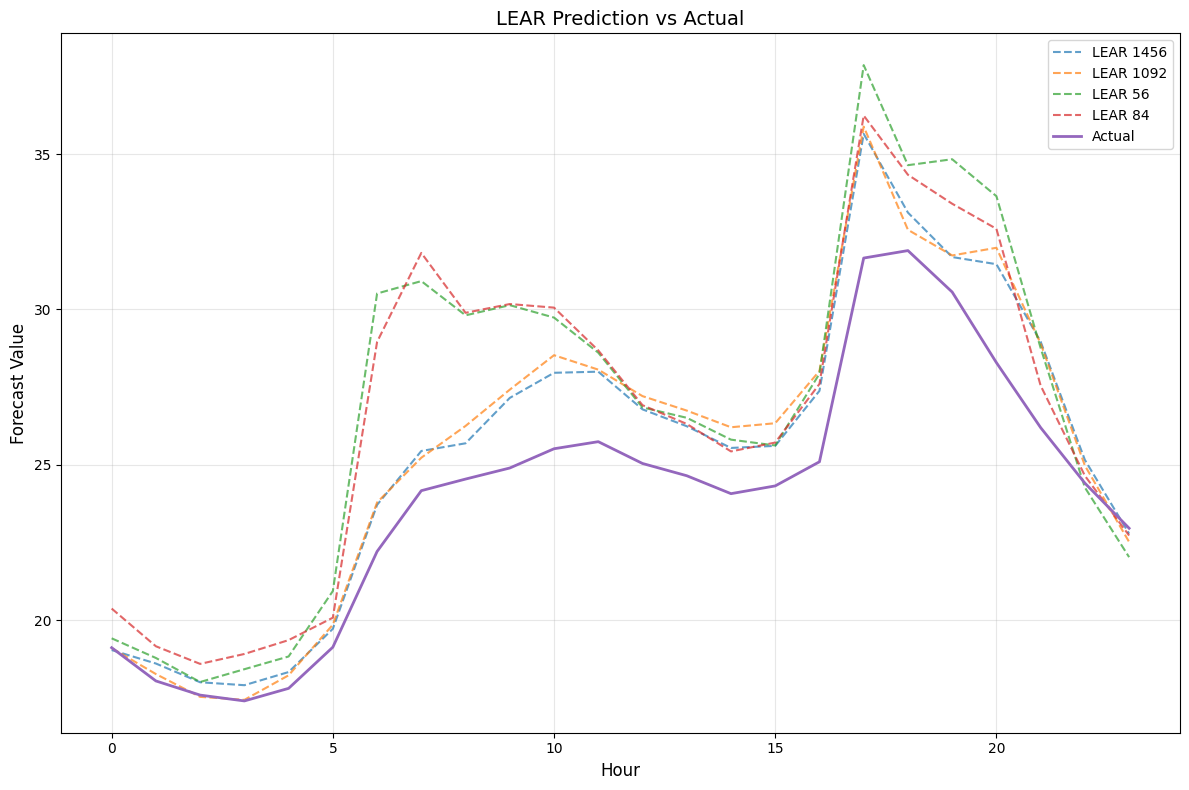

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for column in df_plot.columns:
    if column == 'actual':
        plt.plot(df_plot[column], label=column.capitalize(), linestyle='-', linewidth=2)
    else:
        plt.plot(df_plot[column], label=column.replace('_', ' '), linestyle='--', alpha=0.7)

plt.xlabel("Hour", fontsize=12)
plt.ylabel("Forecast Value", fontsize=12)
plt.title("LEAR Prediction vs Actual", fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Calculate metrics for accuracy

In [93]:
# Import accuracy metrics from epftoolbox
from epftoolbox.evaluation import MAE, RMSE, MAPE, sMAPE, MASE, rMAE
import pandas as pd
import numpy as np

# Get actual values and predictions from collector
actual = np.array(_collector['actual'])
lear_models = ['LEAR_1456', 'LEAR_1092', 'LEAR_56', 'LEAR_84']

# For MASE and rMAE with m=None, we need DataFrames with datetime index
# Create datetime index for the target day (2016-12-27, 24 hours)
target_date = pd.to_datetime('2016-12-27 00:00:00')
datetime_index = pd.date_range(start=target_date, periods=24, freq='1h')
actual_df = pd.DataFrame(actual, index=datetime_index, columns=['Price'])

# For MASE, use df_train as DataFrame (not .values) when m=None
# Use df_train[['Price']] to keep it as DataFrame with datetime index
p_real_in = df_train[['Price']]

# Prepare results dictionary
results = {}

# Calculate metrics for each LEAR model
for model_name in lear_models:
    predictions = np.array(_collector[model_name])
    # print(predictions)
    predictions_df = pd.DataFrame(predictions, index=datetime_index, columns=['Price'])
    
    # Calculate standard metrics (work with numpy arrays)
    mae_val = MAE(p_real=actual, p_pred=predictions)
    rmse_val = RMSE(p_real=actual, p_pred=predictions)
    mape_val = MAPE(p_real=actual, p_pred=predictions) * 100  # Convert to percentage
    smape_val = sMAPE(p_real=actual, p_pred=predictions) * 100  # Convert to percentage
    
    # For MASE with m=None, need DataFrames with datetime index
    mase_val = MASE(p_real=actual_df, p_pred=predictions_df, p_real_in=p_real_in, m=None)
    
    # For rMAE: with a single day (24 hours), we can't use m=None (needs week of data)
    # Instead, calculate rMAE manually using the one-step ahead naive forecast formula:
    # rMAE = MAE / (1/(N-1) * sum(|p_i - p_{i-1}|))
    # This is the standard rMAE for one-step ahead forecasting
    naive_mae = np.mean(np.abs(actual[1:] - actual[:-1]))  # MAE of one-step ahead naive forecast
    if naive_mae > 0:
        rmae_val = mae_val / naive_mae
    else:
        rmae_val = np.nan
    
    results[model_name] = {
        'MAE': mae_val,
        'RMSE': rmse_val,
        'MAPE (%)': mape_val,
        'sMAPE (%)': smape_val,
        'MASE': mase_val,
        'rMAE': rmae_val
    }

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame(results).T
print("Accuracy Metrics for LEAR Models (One-day prediction: 2016-12-27)")
print("=" * 70)
print(metrics_df.round(4))
print("\nNote: MAPE and sMAPE are shown as percentages.")
print("MASE and rMAE values < 1 indicate better performance than naive forecast.")
print("rMAE is calculated using one-step ahead naive forecast (previous hour's price).")


Accuracy Metrics for LEAR Models (One-day prediction: 2016-12-27)
              MAE    RMSE  MAPE (%)  sMAPE (%)    MASE    rMAE
LEAR_1456  1.4642  1.7604    5.7748     5.5634  0.2336  1.1818
LEAR_1092  1.6043  1.9961    6.2627     5.9912  0.2559  1.2949
LEAR_56    2.9057  3.6628   11.6195    10.6746  0.4636  2.3453
LEAR_84    2.6963  3.3618   11.0239    10.1846  0.4302  2.1762

Note: MAPE and sMAPE are shown as percentages.
MASE and rMAE values < 1 indicate better performance than naive forecast.
rMAE is calculated using one-step ahead naive forecast (previous hour's price).


# DNN one-shot replication (PJM)

## DNN one-shot (lookup from published forecasts)

The repo does not ship the DNN weights/training code for a quick one-shot run here. To inspect the published DNN outputs (e.g., DNN 1) for 2016-12-27, we can read them from the benchmark forecasts CSV.


In [7]:
# Load published forecasts and show DNN 1 for the target date
forecast_csv = 'forecasts/Forecasts_PJM_DNN_LEAR_ensembles.csv'
df_pub = pd.read_csv(forecast_csv)

# Extract first day (2016-12-27) 24-hour DNN 1
print("Published DNN 1 (2016-12-27):")
print(df_pub.loc[:24, 'DNN 1'].to_list())



Published DNN 1 (2016-12-27):
[19.70612335205078, 18.578807830810547, 17.405715942382812, 16.994461059570312, 18.000518798828125, 20.2280216217041, 24.20281219482422, 26.076431274414062, 25.93037223815918, 26.751548767089844, 27.29048156738281, 26.98875617980957, 26.584705352783203, 26.50397682189941, 26.20037651062012, 26.297685623168945, 28.09921264648437, 35.058292388916016, 32.93193817138672, 30.90234375, 28.85091018676757, 26.48240089416504, 24.27153396606445, 22.61918830871582, 22.26004409790039]


## DNN one-shot with hyperparameter search

DNN starts with a pre-selected set of hyperparamters. In this one-shot demo, we first conduct the search and then create DNN prediction.


In [74]:
# Broader hyperparameter search for one-shot DNN (per Lago et al. best-practice: widen space)
# Runtime note: max_evals=50 is a compromise; raise if you want more exploration.

# Searching over 20 iterations is sufficient
import os
from pathlib import Path
from epftoolbox.models import hyperparameter_optimizer

exp_id = 'oneshot_dnn'
data_path = Path('datasets')
work_path = Path('experimental_files')
work_path.mkdir(parents=True, exist_ok=True)

# Relaxed search space knobs
nlayers = 3            # allow up to 3 layers instead of fixing at 2
shuffle_train = 1      # keep shuffling on
data_augmentation = 1  # enable augmentation to explore that dimension
calibration_window = 4 # keep CW consistent with paper baseline
years_test = 2
max_evals = 50         # moderate search budget; increase to 100+ if time permits


In [ ]:
# Long run - 50 iterations may be enough

trials_file_name = (
    f'DNN_hyperparameters_nl{nlayers}_datPJM_YT{years_test}'
    f"{'_SF' if shuffle_train else ''}"
    f"{'_DA' if data_augmentation else ''}"
    f'_CW{calibration_window}_ME{max_evals}_{exp_id}'
)
trials_path = work_path / trials_file_name

if trials_path.exists():
    print('Trials file already exists, skipping hyperparameter search:')
    print(trials_path)
else:
    print('Running a broader hyperparameter search to create trials file...')
    hyperparameter_optimizer(
        path_datasets_folder=str(data_path),
        path_hyperparameters_folder=str(work_path),
        new_hyperopt=True,
        max_evals=max_evals,
        nlayers=nlayers,
        dataset='PJM',
        years_test=years_test,
        calibration_window=calibration_window,
        shuffle_train=bool(shuffle_train),
        data_augmentation=bool(data_augmentation),
        experiment_id=exp_id,
        begin_test_date=None,
        end_test_date=None,
    )
    print('Saved trials to:', trials_path)


In [75]:
%%time
# Minimal DNN run for a single test day (2016-12-27)
from epftoolbox.models import evaluate_dnn_in_test_dataset

# Define a single-day test window
begin_test_date = '27/12/2016 00:00'
end_test_date = '27/12/2016 00:00'  # Trick for getting at one day estimate - begin_test_date = end_test_date, where the 24 data points are estimated anyways.

# This will train/recalibrate once and produce a forecast for that day only
import os
os.makedirs('forecasts_local', exist_ok=True)

forecast_dnn = evaluate_dnn_in_test_dataset(
    experiment_id=exp_id,  # must match the hyperopt run above
    path_datasets_folder='datasets',
    path_hyperparameter_folder='experimental_files',
    path_recalibration_folder='forecasts_local',
    dataset='PJM',
    years_test=2,  # ignored when begin/end are provided
    begin_test_date=begin_test_date,
    end_test_date=end_test_date,
    new_recalibration=True,  # force a fresh run instead of loading a prior CSV
)

# Show the 24-hour DNN forecast for 2016-12-27
print("DNN forecast for 2016-12-27 (single-day run):")
print(forecast_dnn.iloc[0].values.tolist())



Test datasets: 2016-12-27 00:00:00 - 2016-12-27 23:00:00


2025-12-11 09:33:19.916091: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-11 09:33:19.940538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-11 09:33:19.943721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2016-12-27 - sMAPE: 5.06%  |  MAE: 1.267
DNN forecast for 2016-12-27 (single-day run):
[19.294963836669922, 18.62704086303711, 17.639341354370117, 17.075611114501953, 17.620248794555664, 19.65627098083496, 23.593128204345703, 26.24408531188965, 26.174697875976562, 26.483139038085938, 26.38486099243164, 25.419456481933594, 23.552978515625, 23.27328872680664, 22.845041275024414, 23.57034683227539, 24.70502471923828, 29.57394790649414, 29.331645965576172, 26.998889923095703, 27.177997589111328, 24.676305770874023, 22.29446792602539, 20.472434997558594]
CPU times: user 34.9 s, sys: 3.09 s, total: 38 s
Wall time: 36.1 s


In [76]:
forecast_dnn

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-27,19.294964,18.627041,17.639341,17.075611,17.620249,19.656271,23.593128,26.244085,26.174698,26.483139,...,22.845041,23.570347,24.705025,29.573948,29.331646,26.99889,27.177998,24.676306,22.294468,20.472435


In [77]:
# Now, print out the columns for the chosen date - 2016-12-27
chosen_date = '2016-12-27'
# Filter the DataFrame to rows matching the chosen date
# Filter to rows for the chosen date
chosen_day_rows = published[published['Unnamed: 0'].str.startswith(chosen_date)]
# Select only the 'D1' to 'D4' columns and transpose them
chosen_day_d1_to_d4_transposed = chosen_day_rows[["DNN 1", "DNN 2", "DNN 3", "DNN 4"]].transpose()
# Print all columns for that day
chosen_day_d1_to_d4_transposed

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DNN 1,19.706123,18.578808,17.405716,16.994461,18.000519,20.228022,24.202812,26.076431,25.930372,26.751549,...,26.200377,26.297686,28.099213,35.058292,32.931938,30.902344,28.850910,26.482401,24.271534,22.619188
DNN 2,19.040689,18.628008,17.954073,17.322933,18.452641,20.440174,23.291067,24.964016,25.283371,25.792505,...,24.917231,24.875704,26.216167,32.241158,30.142319,27.851013,27.114426,25.712709,23.455555,21.299164
DNN 3,19.661985,18.581722,17.564003,16.941095,17.457172,19.158525,22.370064,24.356388,25.467987,26.748640,...,25.531353,25.147465,27.194950,33.391148,31.513958,29.097511,28.769260,26.781998,23.786240,22.003754
DNN 4,18.857361,17.804329,16.387474,15.673610,15.920693,18.623030,22.651892,24.700928,24.950792,25.070341,...,23.515644,23.333128,25.200039,31.157816,30.578306,28.333342,28.451826,26.250410,23.073729,21.108505


In [78]:
import pandas as pd
df_PJM = pd.read_csv('datasets/hourly_data_all_markets.csv')
df_PJM = df_PJM[df_PJM['mkt'] == 'PJM']
actual_value = df_PJM[pd.to_datetime(df_PJM['DateTime']).dt.date == pd.to_datetime('2016-12-27').date()]['Price'].values.tolist()

In [79]:
import pandas as pd

dataLabels = ['rerun', 'DNN 1', 'DNN 2', 'DNN 3', 'DNN 4', 'actual']
styling_of_plots = ['--', '-', '-', '-', '-', ':']  # Last one distinctly dotted for 'actual'
df = pd.DataFrame([
    forecast_dnn.iloc[0].values.tolist(),
    *chosen_day_d1_to_d4_transposed.values.tolist(),
    actual_value
], index=dataLabels)

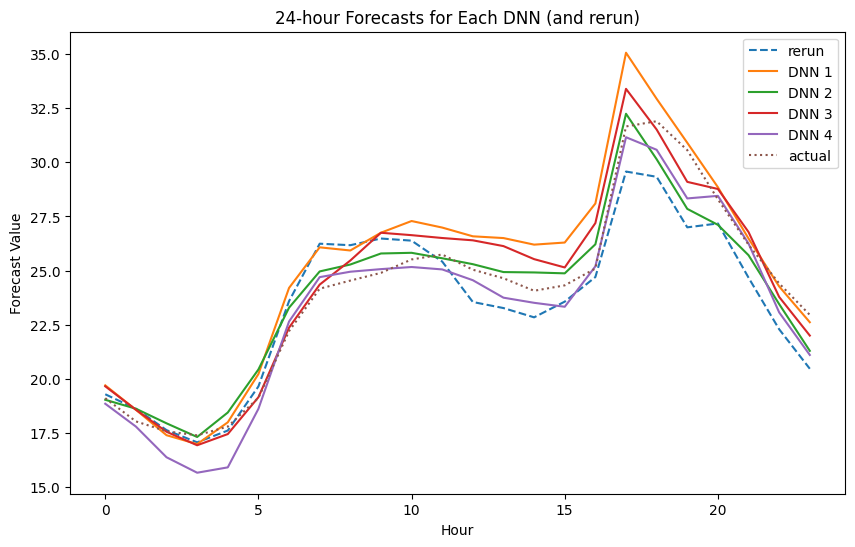

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, (idx, row) in enumerate(df.iterrows()):
    plt.plot(row.values, label=idx, linestyle=styling_of_plots[i])
plt.xlabel("Hour")
plt.ylabel("Forecast Value")
plt.title("24-hour Forecasts for Each DNN (and rerun)")
plt.legend()
plt.show()

In [81]:
forecast_dnn

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-27,19.294964,18.627041,17.639341,17.075611,17.620249,19.656271,23.593128,26.244085,26.174698,26.483139,...,22.845041,23.570347,24.705025,29.573948,29.331646,26.99889,27.177998,24.676306,22.294468,20.472435


# Old for reference

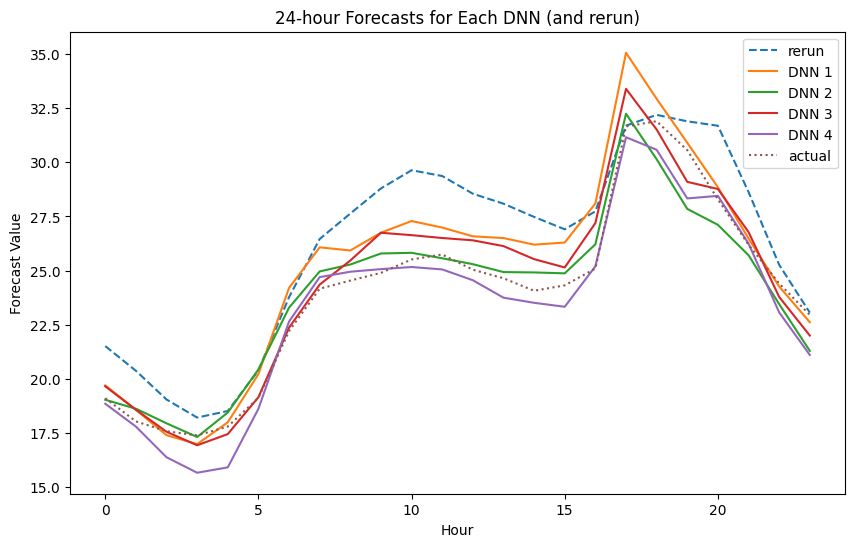

In [ ]:
# Old plot with 5 iterations (saved for reference)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, (idx, row) in enumerate(df.iterrows()):
    plt.plot(row.values, label=idx, linestyle=styling_of_plots[i])
plt.xlabel("Hour")
plt.ylabel("Forecast Value")
plt.title("24-hour Forecasts for Each DNN (and rerun)")
plt.legend()
plt.show()

# Calculate Accuracy

In [88]:
_collector_dnn = {
    # These is taken from noetbook:
    # Notebooks/02_forecasting_oneshot-DNN-1year.ipynb
    'rerun_DNN_1year': [19.449634552001953, 18.56810760498047, 17.62259864807129,
        17.147357940673828, 17.58217430114746, 19.477371215820312,
        23.781896591186523, 26.33660316467285, 26.208879470825195,
        26.380971908569336, 26.03837776184082, 24.918434143066406,
        23.752811431884766, 23.38079261779785, 22.87982177734375,
        23.20714569091797, 24.48593521118164, 29.28615379333496,
        29.39154624938965, 27.19342041015625, 27.029258728027344,
        24.766008377075195, 22.42184829711914, 20.777116775512695],
     'rerun_DNN_4years': list(forecast_dnn.values[0])
}

In [89]:
_collector_dnn

{'rerun_DNN_1year': [19.449634552001953,
  18.56810760498047,
  17.62259864807129,
  17.147357940673828,
  17.58217430114746,
  19.477371215820312,
  23.781896591186523,
  26.33660316467285,
  26.208879470825195,
  26.380971908569336,
  26.03837776184082,
  24.918434143066406,
  23.752811431884766,
  23.38079261779785,
  22.87982177734375,
  23.20714569091797,
  24.48593521118164,
  29.28615379333496,
  29.39154624938965,
  27.19342041015625,
  27.029258728027344,
  24.766008377075195,
  22.42184829711914,
  20.777116775512695],
 'rerun_DNN_4years': [19.294963836669922,
  18.62704086303711,
  17.639341354370117,
  17.075611114501953,
  17.620248794555664,
  19.65627098083496,
  23.593128204345703,
  26.24408531188965,
  26.174697875976562,
  26.483139038085938,
  26.38486099243164,
  25.419456481933594,
  23.552978515625,
  23.27328872680664,
  22.845041275024414,
  23.57034683227539,
  24.70502471923828,
  29.57394790649414,
  29.331645965576172,
  26.998889923095703,
  27.17799758911

In [ ]:
# do percision calculation again


In [91]:
# Import accuracy metrics from epftoolbox
from epftoolbox.evaluation import MAE, RMSE, MAPE, sMAPE, MASE, rMAE
import pandas as pd
import numpy as np

# Get actual values and DNN predictions from collectors
actual = np.array(_collector['actual'])
dnn_models = ['rerun_DNN_1year', 'rerun_DNN_4years']

# For MASE and rMAE with m=None, we need DataFrames with datetime index
# Create datetime index for the target day (2016-12-27, 24 hours)
target_date = pd.to_datetime('2016-12-27 00:00:00')
datetime_index = pd.date_range(start=target_date, periods=24, freq='1h')
actual_df = pd.DataFrame(actual, index=datetime_index, columns=['Price'])

# For MASE, use df_train as DataFrame (not .values) when m=None
# Use df_train[['Price']] to keep it as DataFrame with datetime index
p_real_in = df_train[['Price']]

# Prepare results dictionary
results_dnn = {}

# Calculate metrics for each DNN model
for model_name in dnn_models:
    predictions = np.array(_collector_dnn[model_name])
    predictions_df = pd.DataFrame(predictions, index=datetime_index, columns=['Price'])
    
    # Calculate standard metrics (work with numpy arrays)
    mae_val = MAE(p_real=actual, p_pred=predictions)
    rmse_val = RMSE(p_real=actual, p_pred=predictions)
    mape_val = MAPE(p_real=actual, p_pred=predictions) * 100  # Convert to percentage
    smape_val = sMAPE(p_real=actual, p_pred=predictions) * 100  # Convert to percentage
    
    # For MASE with m=None, need DataFrames with datetime index
    mase_val = MASE(p_real=actual_df, p_pred=predictions_df, p_real_in=p_real_in, m=None)
    
    # For rMAE: with a single day (24 hours), we can't use m=None (needs week of data)
    # Instead, calculate rMAE manually using the one-step ahead naive forecast formula:
    # rMAE = MAE / (1/(N-1) * sum(|p_i - p_{i-1}|))
    # This is the standard rMAE for one-step ahead forecasting
    naive_mae = np.mean(np.abs(actual[1:] - actual[:-1]))  # MAE of one-step ahead naive forecast
    if naive_mae > 0:
        rmae_val = mae_val / naive_mae
    else:
        rmae_val = np.nan
    
    results_dnn[model_name] = {
        'MAE': mae_val,
        'RMSE': rmse_val,
        'MAPE (%)': mape_val,
        'sMAPE (%)': smape_val,
        'MASE': mase_val,
        'rMAE': rmae_val
    }

# Create a DataFrame for better visualization
metrics_dnn_df = pd.DataFrame(results_dnn).T
print("Accuracy Metrics for DNN Models (One-day prediction: 2016-12-27)")
print("=" * 70)
print(metrics_dnn_df.round(4))
print("\nNote: MAPE and sMAPE are shown as percentages.")
print("MASE and rMAE values < 1 indicate better performance than naive forecast.")
print("rMAE is calculated using one-step ahead naive forecast (previous hour's price).")


Accuracy Metrics for DNN Models (One-day prediction: 2016-12-27)
                     MAE    RMSE  MAPE (%)  sMAPE (%)    MASE    rMAE
rerun_DNN_1year   1.2724  1.5224    4.9847     5.0604  0.2030  1.0270
rerun_DNN_4years  1.2668  1.5439    4.9759     5.0597  0.2021  1.0225

Note: MAPE and sMAPE are shown as percentages.
MASE and rMAE values < 1 indicate better performance than naive forecast.
rMAE is calculated using one-step ahead naive forecast (previous hour's price).
